<a href="https://colab.research.google.com/github/k4west/Baekjoon_Python/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transformer 모델과 🤗Transformers 소개  
##🤗로 시작하는 AI 스터디 Week 10
##학습범위: 요약 Chapter 6

발표자: 박현상

*발표자료와 실습자료를 이 문서로 통합


목차  

1. CNN/DailyMail 데이터셋   

2. 텍스트 요약 파이프라인  
2-1. 요약 기준 모델  
2-2. GPT-2  
2-3. T5  
2-4. BART
2-5. PEGASUS

3. 요약 결과 비교하기  
3-1. 트랜스포머를 특성 추출기로 사용  
3-2. 트랜스포머 미세 튜닝
  
4. 생성된 텍스트 품질 평가하기  
4-1. BLEU  
4-2. ROGUE

5. CNN/DailyMail 데이터셋에서 PEGASUS 평가하기
  
6. 요약 모델 훈련하기  
6-1. SAMsum에서 PEGASUS 평가하기  
6-2. PEGASUS 미세 튜닝하기  
6-3. 대화 요약 생성하기  

7. 결론

## 1. CNN/DailyMail 데이터셋

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.2 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

특성: ['article', 'highlights', 'id']


In [5]:
sample = dataset["train"][1]
print(f"""기사 ( 500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f"\n요약 (길이: {len(sample['highlights'])}):")
print(sample["highlights"])

기사 ( 500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## 2. 텍스트 요약 파이프라인

In [6]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [7]:
! pip install nltk
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The U.S. are a country.', 'The U.N. is an organization.']

### 2-2. 요약 기준 모델

In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

### 2-2. GPT-2

In [9]:
! pip install transformers
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2")  # gpt2-xl 모델을 사용하면 나중에 터질거 같아서 gpt2 사용했습니다.
gpt2_query = sample_text +"\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) : ]))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### 2-3. T5

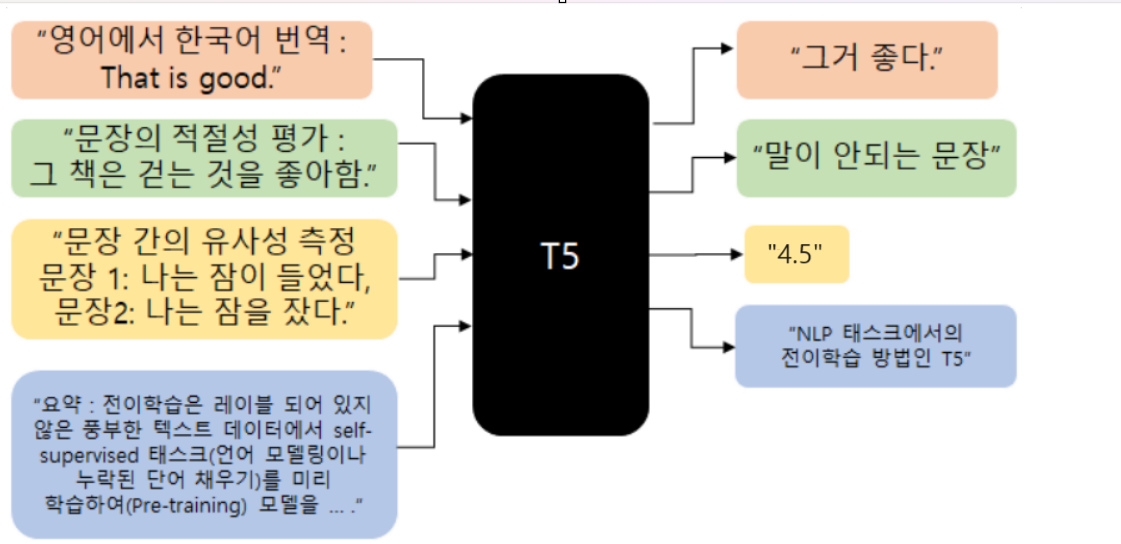
  
출처 :
https://researcher-hj.tistory.com/entry/T5-%ED%85%8D%EC%8A%A4%ED%8A%B8-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%A0%84%EC%9D%B4-%ED%8A%B8%EB%9E%98%EC%8A%A4%ED%8F%AC%EB%A8%B8

CoLA와 STSB는 자연어 처리(NLP) 관련 작업에 사용되는 벤치마크 데이터셋입니다. 이러한 데이터셋은 NLP 모델의 성능을 평가하고 비교하는 데 사용됩니다. 아래에서 각각의 데이터셋에 대해 설명하겠습니다:

CoLA (Corpus of Linguistic Acceptability):

목적: CoLA 데이터셋은 문장의 문법적 표현의 품질을 측정하고 평가하기 위해 사용됩니다. 즉, 주어진 문장이 문법적으로 올바른지 여부를 판단하는 작업에 모델을 훈련하고 평가하는 데 사용됩니다.
데이터 형식: 이 데이터셋은 문장들의 집합으로 구성되며, 각 문장은 "문법적으로 허용 가능한" 또는 "허용 불가능한"으로 레이블링되어 있습니다. 레이블은 이진 분류(0 또는 1)로 표시됩니다.
예시: "She loves him." (허용 가능한) vs. "Him loves she." (허용 불가능한)
STSB (Semantic Textual Similarity Benchmark):

목적: STSB 데이터셋은 문장 쌍의 의미적 유사성을 측정하고 평가하기 위해 사용됩니다. 주어진 두 문장이 얼마나 의미적으로 비슷한지 점수로 평가하는 작업에 모델을 훈련하고 평가하는 데 사용됩니다.
데이터 형식: 이 데이터셋은 문장 쌍의 집합으로 구성되며, 각 쌍은 0에서 5 사이의 연속적인 점수로 평가됩니다. 점수가 높을수록 문장 쌍이 의미적으로 더 유사합니다.
예시:
"A soccer game with multiple males playing." vs. "Some men are playing a sport." (의미적으로 유사함, 점수: 4.5)
"A group of kids is playing in a yard." vs. "A group of children is playing in the field." (의미적으로 매우 유사함, 점수: 5.0)
CoLA는 주로 문법 및 언어 구조에 관한 모델의 성능을 평가하는 데 사용되며, STSB는 문장 의미의 이해와 비교에 관한 모델의 성능을 평가하는 데 사용됩니다. 이러한 벤치마크 데이터셋은 NLP 연구에서 모델의 품질을 평가하고 다른 모델과 비교하는 데 중요한 도구로 사용됩니다.

In [10]:
pipe = pipeline("summarization", model="t5-small") # t5-large 모델을 사용하면 나중에 터질거 같아서 small 사용했습니다.
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### 2-4. BART

In [11]:
pipe = pipeline("summarization", model = "facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### 2-5.PEGASUS

In [12]:
# !pip install -U transformers
# !pip install sentencepiece
# !pip install protobuf
# pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
# pipe_out = pipe(sample_text)
# summaries["pegasus"] = pipe_out[0]["summary_text"].replace("<n>", ".\n")
# 계속 코랩에서 오류가 나서,, 로컬로 돌렸는데 실행되길래 저장하고 로드했습니다..

file_path = "/content/drive/MyDrive/Colab Notebooks/summary.txt"
# 파일 내용 읽기
with open(file_path, "r", encoding="utf-8") as f:
    loaded_text = f.read()
summaries["pegasus"] = loaded_text

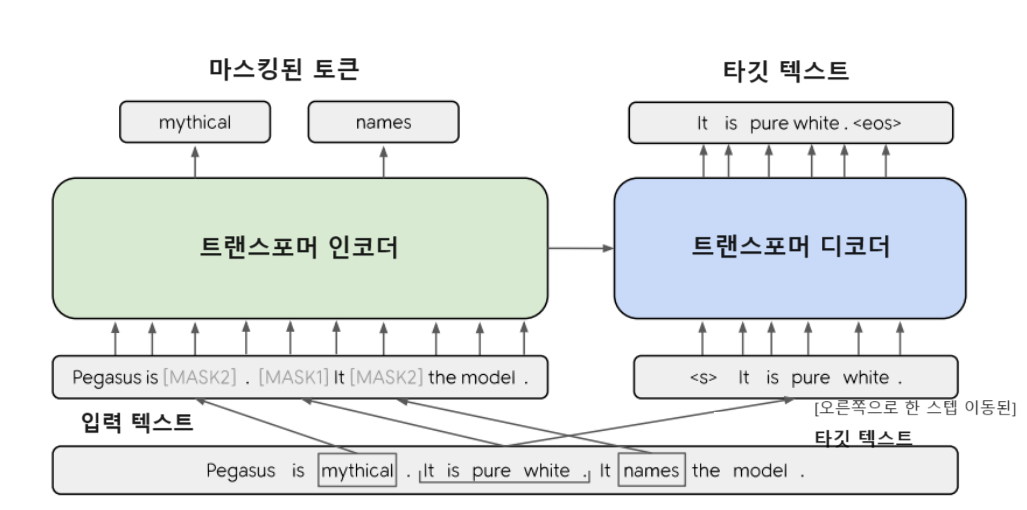

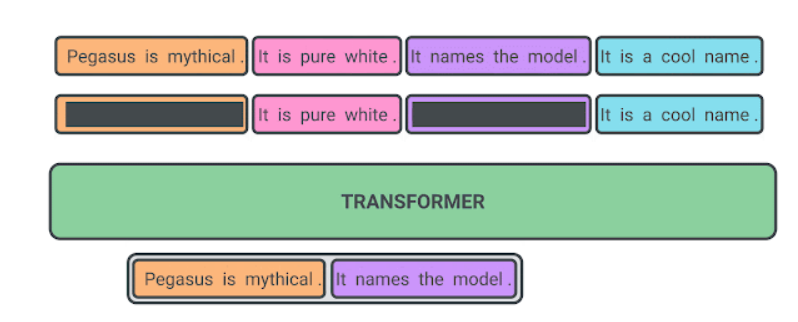

<'s'> (Start of Sentence 또는 Beginning of Sentence) :  

<'s'> 토큰은 문장의 시작을 나타내는 특별한 토큰입니다. 모델에게 언어 모델링 작업을 수행할 때 어떤 문장이 시작되는지 알려줍니다. 이 토큰은 일반적으로 디코더의 입력으로 사용됩니다.    
<'eos'>(End of Sentence 또는 End of Sequence) :    

<'eos'>토큰은 문장이나 시퀀스의 끝을 나타내는 특별한 토큰입니다. 모델에게 어떤 문장이 종료되는지 알려주며, 모델 출력에서 시퀀스의 끝을 표시합니다. 이 토큰은 주로 시퀀스 생성 작업에서 활용됩니다.  

## 3. 요약 결과 비교하기

In [13]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2

To be clear, prisoners who feel like they can't go to the other side of the court do not actually face the law, he says.
Instead, they are detained and charged with a crime.
Many prisoners in these cases can't even be

## 4. 생성된 텍스트 품질 평가하기

## 4-1. BLEU

단어 또는 n그램을 체크하여 평가합니다.  
정밀도를 근간으로 합니다.  
생성된 텍스트에서 참조 텍스트의 단어수 / 생성된 텍스트 길이  
예시 : 여러 평가 지표 비교  
참조 텍스트 : the cat is on the mat  
생성된 텍스트 : the the the the the the  
1단계 : 단어 기반의 정밀도 계산  


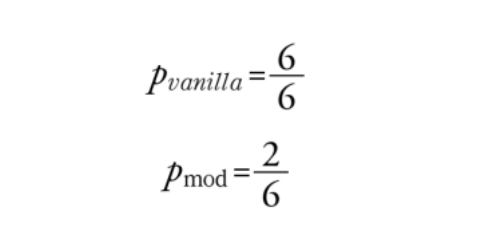

Pvanilla (Vanilla Probability):

가정: 우리가 간단한 텍스트 데이터를 가지고 있다고 가정해봅시다.

텍스트 데이터: "나는 학교에 갔다."

Pvanilla를 사용하여 다음 단어를 예측해보겠습니다. "나는 학교에" 다음에 나올 단어를 예측하려면 Pvanilla는 이전에 나온 단어의 빈도를 세어서 다음 단어를 선택합니다.

"나는" 다음에 나올 단어: "학교에" (Pvanilla는 "나는" 다음에 "학교에"가 자주 나왔다고 가정)
"학교에" 다음에 나올 단어: "갔다." (Pvanilla는 "학교에" 다음에 "갔다."가 자주 나왔다고 가정)
이렇게 Pvanilla는 각 단어의 빈도를 기반으로 다음 단어를 예측합니다.

Pmod (Modified Probability):

이제 Pmod를 사용하여 같은 예시를 살펴보겠습니다. Pmod는 더 많은 문맥과 정보를 고려합니다.

"나는 학교에 갔다." 라는 문장에서, Pmod는 각 단어의 빈도 뿐만 아니라 더 많은 정보를 고려합니다. 예를 들어, "나는" 다음에 "학교에"가 나오는 것뿐만 아니라 "갔다."라는 동사가 문장의 끝에 오는 경향이 있다는 것을 고려합니다.
따라서 Pmod는 Pvanilla보다 더 복잡한 모델을 사용하여 다음 단어를 예측하며, 문맥과 언어 구조를 더 잘 파악할 수 있습니다.

간단히 말해, Pvanilla는 단어의 빈도만을 고려하여 예측하는 반면, Pmod는 더 많은 정보와 문맥을 고려하여 예측하는 방법입니다. 이를 통해 Pmod는 더 정확한 예측을 할 수 있습니다.

2단계 : n-gram 추출하여 계산  
=> 반복적인 생성에 보상을 주지 않도록 클리핑합니다.  
=> 클리핑 :n-그램의 등장 횟수를 카운트하는 것이 참조 문장에 나타난 횟수로 제한합니다.

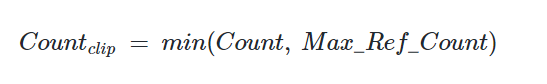  
출처 : https://wikidocs.net/31695

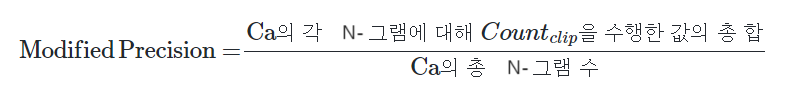

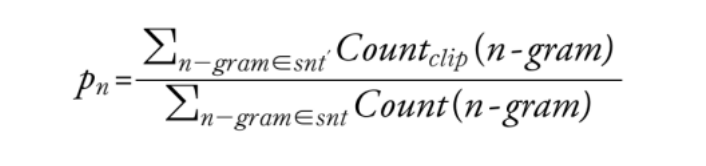

3단계 : 2단계 + 말뭉치 C에 있는 샘플을 더하여 확장합니다.   
=> 테스트 세트에 평가할 샘플이 하나 이상이기 때문에 확장 필요합니다.

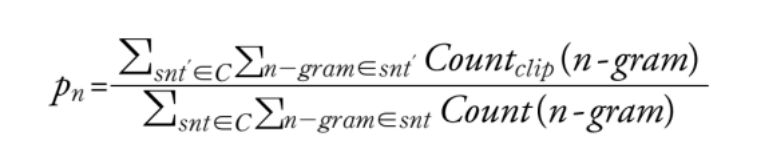

생성된 문장: "the the the the the the the"  
참조 문장1: "the cat is on the mat"    
참조 문장2: "there is a cat on the mat"    

먼저, 유니그램 "the"가 참조 문장(Reference)에서 어떻게 등장하는지를 확인합니다.  

참조 문장1에서 "the"가 3번 등장합니다.  
참조 문장2에서 "the"가 2번 등장합니다.  
Max_Ref_Count 계산:  

"the" 유니그램의 Max_Ref_Count는 두 참조 문장 중에서 가장 작은 등장 횟수인 2가 됩니다.  
정밀도(Precision) 계산:  

기존 BLEU 점수 계산에서는, 유니그램 "the"가 생성된 문장에서 7번 등장했으므로 분자는 7이었습니다.  
하지만 Max_Ref_Count가 도입된 새로운 계산 방식에서는, Max_Ref_Count인 2로 클리핑합니다.  
따라서 분자는 2가 됩니다.  
정밀도 계산 결과:  

분자(기존 카운트 값): 2  
분모(새로운 카운트 값, 생성된 문장의 총 단어 수): 7  
이렇게 계산된 정밀도 값은 BLEU 점수의 일부로 활용되며, 참조 문장에 대한 유사성을 평가하는 데 사용됩니다. 새로운 카운트 방식을 도입함으로써, 과도한 반복되는 단어가 있는 생성된 문장에 불이익을 줄이고, 더 공정한 평가 기준을 제공합니다.  

유니그램 외에도 Bigram, Trigram, 4-gram 단위 등으로 계산한 정밀도. 즉, n-gram을 이용한 정밀도가 있습니다. 유니그램은 단순 단어의 빈도를 계산하여, 어휘의 순서를 고려 못하지만, n-gram은 다음에 등장하는 단어 까지 고려하기 때문에 어휘의 순서가 어느 정도 고려할 수 있습니다.

4단계 : 브레비티(brevity penalty) 추가  
=> 짧은 문장이 긴 문장보다 정밀도가 높게 되는 것에 대한 패널티 부가합니다.  
=> 패널티는 1을 넘지 않습니다.

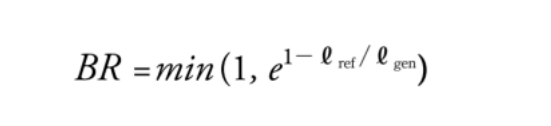

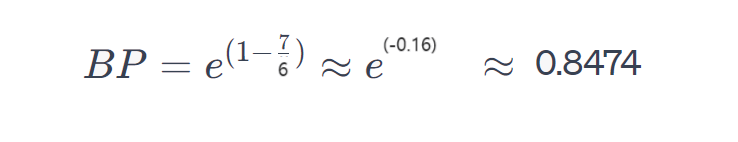

5단계 : 1~4단계를 모두 합하여 평가지표 설계  
=> 1에서 N까지 n-그램에서 수정 정밀도의 기하 평균합니다.  

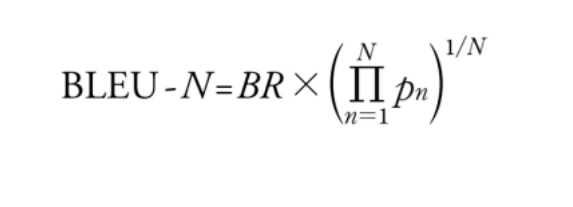

예를 들어, 1-gram (유니그램)과 2-gram (바이그램)에 대한 수정 정밀도를 계산한다고 가정해 봅시다. 이 두 개의 n-그램에 대한 수정 정밀도를 P1와 P2라고 표시하겠습니다. 그리고 이 두 값을 기하 평균하여 수정 정밀도의 기하 평균을 구할 수 있습니다.

수정 정밀도의 기하 평균은 다음과 같이 나타낼 수 있습니다:

GM = (P1 * P2 * ... * PN) ^ (1/N)

여기서 GM은 수정 정밀도의 기하 평균을 나타내며, P1, P2, ..., PN은 각각 1에서 N까지의 n-그램에 대한 수정 정밀도 값을 나타냅니다.

예시:

1-gram (유니그램) 수정 정밀도 (P1) = 0.7
2-gram (바이그램) 수정 정밀도 (P2) = 0.5

이 경우, 수정 정밀도의 기하 평균은 다음과 같이 계산됩니다:

GM = (0.7 * 0.5) ^ (1/2) = √(0.35) ≈ 0.5916

따라서, 이 예시에서 1-gram과 2-gram에 대한 수정 정밀도의 기하 평균은 약 0.5916입니다.

기계 번역에 많이 사용됩니다.(정확한 번역이 선호됨)  
단점(동의어가 고려되지 않음, 토큰화에 따라 결과가 달라집니다.)

In [14]:
!pip install sacrebleu

from datasets import load_metric
bleu_metric = load_metric("sacrebleu")

import pandas as pd
import numpy as np

# BLEU 메트릭에 예측값(prediction)과 참조값(reference)를 추가합니다.
bleu_metric.add(
    prediction="the the the the the the",  # 예측값 (생성된 문장)
    reference=["the cat is on the mat"]  # 참조값 (문장 리스트)
)

# BLEU 점수를 계산합니다.
# smooth_method는 점수를 부드럽게 만들기 위한 방법을 설정할 수 있습니다.
# smooth_value는 부드럽게 만드는 데 사용되는 값입니다.
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)

# 계산된 BLEU 메트릭 결과를 출력합니다.
# 결과 중 precisions는 각 n-gram 정밀도를 나타냅니다.
# 여기서는 각 정밀도를 소수점 2자리까지 반올림하여 출력합니다.
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

# 결과를 Pandas DataFrame 형식으로 변환하여 출력합니다.
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 3.0 MB/s eta 0:00:00


<ipython-input-14-b8e946effc28>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


score: BLEU 점수는 0.0입니다. 이는 예측값과 참조값 간의 일치가 없거나 아주 낮다는 것을 나타냅니다.

counts: n-gram 유형별로 정밀도를 계산하기 위한 카운트입니다. 여기서 [2, 0, 0, 0]은 각각 1-gram, 2-gram, 3-gram, 4-gram에 대한 카운트를 나타냅니다. 이 경우 1-gram에서만 일치하는 것을 볼 수 있습니다. 즉, 예측값에서 참조값과 겹치는 1-gram이 2개 있습니다.

totals: 참조값에서 각 n-gram 유형에 대한 총 단어 수를 나타냅니다. [6, 5, 4, 3]은 각각 1-gram, 2-gram, 3-gram, 4-gram에 대한 참조값의 총 단어 수입니다.

precisions: 각 n-gram 유형별로 정밀도를 계산한 결과를 나타냅니다. 1-gram 정밀도는 33.33%로, 2-gram 이상의 n-gram에 대해서는 일치하는 것이 없으므로 0.0으로 나타납니다.

bp: 브레버티 패널티(Brevity Penalty)는 1.0으로 나타납니다. 이는 예측 문장의 길이와 가장 가까운 참조 문장의 길이 간의 비율을 나타냅니다. 이 경우 예측 문장과 참조 문장의 길이가 동일하므로 패널티가 적용되지 않습니다.

sys_len: 예측 문장의 총 단어 수를 나타냅니다. 이 경우 6개의 단어로 이루어진 예측 문장입니다.

ref_len: 참조값 중 가장 가까운 참조 문장의 총 단어 수를 나타냅니다. 이 경우 6개의 단어로 이루어진 참조 문장입니다.

In [15]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### 4-2. ROUGE

BLEU와의 차별점 : 참조 텍스트에 있는 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지 확인합니다.  
클리핑 사용 안 합니다.


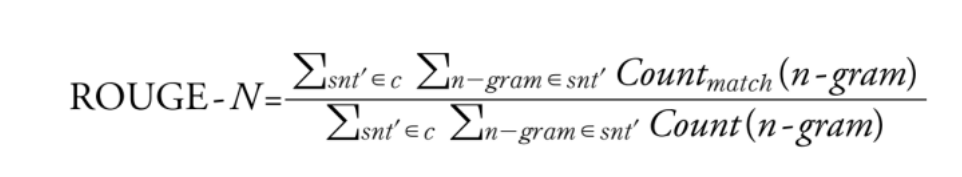

ROUGE-N = (모델 예측과 참조 간의 n-gram 일치 개수) / (참조의 총 n-gram 수)

긴 문장이 유리하여 F-점수와 같은 방식으로 각 샘플을 정규화합니다.

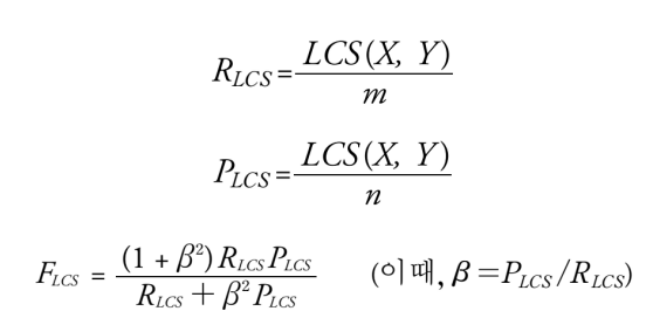

m = 참조 텍스트, n= 생성 텍스트길이

RLCS (Recall of Longest Common Subsequence):  
RLCS는 재현율을 나타냅니다.  

    
PLCS (Precision of Longest Common Subsequence):  
PLCS는 정밀도를 나타냅니다.

    
FLCS (F-Measure of Longest Common Subsequence):  
FLCS는 F-점수를 나타냅니다.  

cf. "LCS(수열)"은 시퀀스의 요소(예: 문자 또는 단어)를 나열한 것을 의미합니다.   
예를 들어, "ABCD"와 "ACDF"라는 두 문자열이 있다면, 이들의 LCS는 "ACD"입니다.

In [16]:
!pip install rouge_score

rouge_metric = load_metric("rouge")

reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=ba6c26b8570aa848ecfe8c9b7364397a0b16d8f76746feefd4a17ca2494dcd33
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.258621,0.035088,0.120690,0.241379
t5,0.195652,0.022222,0.108696,0.173913
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.326531,0.208333,0.285714,0.326531


ROUGE-1:  
ROUGE-1은 1-gram, 즉 단어 단위의 정밀도와 재현율을 기반으로 하는   메트릭입니다.   이 메트릭은 예측된 문장과 참조 문장 간에 동일한 단어가 얼마나   많이 포함되었는지를 측정합니다. ROUGE-1은 단어 수준의 일치를 고려하며,   정밀도와 재현율을 계산하여 F1-점수를 얻습니다.   

ROUGE-2:  
ROUGE-2는 2-gram, 즉 두 단어씩 연속적으로 나타나는 단어 쌍의 정밀도와   재현율을 기반으로 하는 메트릭입니다. 이 메트릭은 예측된 문장과 참조 문장 간에 연속된 단어 쌍의 일치를 측정합니다. ROUGE-2는 1-gram 이상의 연속성을   고려하며, 정밀도와 재현율을 계산하여 F1-점수를 얻습니다.  

ROUGE-L:  
ROUGE-L은 "Longest Common Subsequence"의 약자로, 예측된 문장과 참조 문장 사이에서 가장 긴 공통 부분 수열 (LCS)의 길이를 기반으로 합니다. 이 메트릭은 예측된 문장과 참조 문장 간에 얼마나 많은 내용이 일치하는지를 측정합니다. ROUGE-L은 정밀도와 재현율을 계산하여 F1-점수를 얻습니다.

ROUGE-Lsum:  
ROUGE-Lsum은 ROUGE-L 메트릭을 다수의 참조 문장에 대한 평균값으로 계산하는 것입니다. 이 메트릭은 요약 작업에서 다수의 참조 문장을 고려하여 평가하는 데 사용됩니다. ROUGE-Lsum은 다수의 참조 문장을 통해 요약 결과의 일반성을 평가하며, 정밀도와 재현율을 계산하여 F1-점수를 얻습니다.

## 5. CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [17]:
def evaluate_summaries_baseline(dataset, metric,
                                  column_text="article",
                                  column_summary="highlights"):
    # 데이터셋에서 각 기사에 대한 요약을 생성합니다.
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]

    # 생성된 요약을 예측(prediction)으로 추가하고, 데이터셋에서 가져온 요약을 참조(reference)로 추가합니다.
    metric.add_batch(predictions=summaries, references=dataset[column_summary])

    # 지정된 메트릭을 사용하여 평가 점수를 계산합니다.
    score = metric.compute()

    # 계산된 평가 점수를 반환합니다.
    return score



In [18]:
# "test" 데이터셋에서 1000개의 샘플을 임의로 선택하고 섞습니다.
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

# evaluate_summaries_baseline 함수를 호출하여 요약문 성능을 측정하고 스코어를 반환합니다.
score = evaluate_summaries_baseline(test_sampled, rouge_metric)

# ROUGE 메트릭에서 얻은 스코어를 각 ROUGE 유형(ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum)에 대한 딕셔너리 형태로 변환합니다.
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

# 데이터프레임을 생성하여 ROUGE 스코어를 출력합니다.
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [19]:
from tqdm import tqdm
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"

# 리스트를 배치 단위로 분할하는 함수 정의
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

# Pegasus 모델을 사용하여 요약 문장 생성 및 평가를 수행하는 함수 정의
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    # 입력 데이터와 타겟 데이터를 배치 단위로 분할
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    # 배치 단위로 루프를 실행하면서 요약 생성 및 평가 수행
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        # 텍스트를 Pegasus 모델에 맞게 전처리 (토크나이징, 패딩 등)
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        # 빔 서치를 사용하여 요약 생성
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        # 생성된 요약 문장 디코딩
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        # <n> 토큰을 공백으로 대체하고, 디코딩된 요약 문장과 참조 문장을 평가 지표에 추가
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    # 평가 지표를 계산하여 반환
    score = metric.compute()
    return score


In [20]:
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# model_ckpt = "google/pegasus-cnn_dailymail"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
# score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
#                                    model, tokenizer, batch_size=8)
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=["pegasus"])



In [22]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_save_path = "/content/drive/MyDrive/Colab Notebooks/pegasus_model"

loaded_model = AutoModelForSeq2SeqLM.from_pretrained(model_save_path)
# tokenizer = AutoTokenizer.from_pretrained(model_save_path, use_fast=False)
# score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
#                                    model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.389276,0.171296,0.245061,0.354239


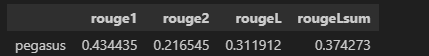

## 6.요약 모델 훈련하기

In [23]:
!pip install py7zr
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할크기 : {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\n요약:")
print(dataset_samsum["test"][0]["summary"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.3 MB/s eta 0:00:00


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

분할크기 : [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### 6-1. SAMSum에서 PEGASUS 평가하기

In [24]:
# # pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
# pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
# print("Summary:")
# print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

# score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
#                                    tokenizer, column_text="dialogue",
#                                    column_summary="summary", batch_size=8)

# # rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# # pd.DataFrame(rouge_dict, index=["pegasus"])


In [25]:
model_save_path = "/content/drive/MyDrive/Colab Notebooks/samsum_pegasus_model"

loaded_model = AutoModelForSeq2SeqLM.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

# tokenizer = AutoTokenizer.from_pretrained(model_save_path, use_fast=False)
# score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
#                                    tokenizer, column_text="dialogue",
#                                    column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.389276,0.171296,0.245061,0.354239


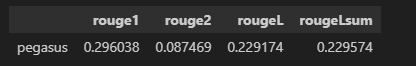

### 6-2 PEGASUS 미세튜닝하기

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


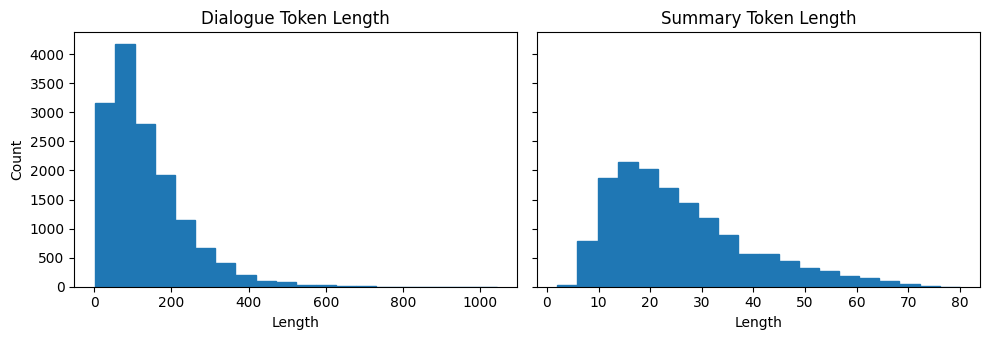

In [26]:
! pip install matplotlib
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [27]:
# 데이터를 모델 입력 특성으로 변환하는 함수 정의
def convert_examples_to_features(example_batch):
    # 대화 (dialogue) 텍스트를 토크나이즈하여 입력 특성을 생성
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    # 요약 (summary) 텍스트를 대상 토크나이저로 변환하여 대상 특성을 생성
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    # 입력 및 대상 특성을 반환
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

# 데이터셋을 PyTorch 형식으로 변환하여 설정
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

# 텍스트 데이터 예시 생성 및 데이터프레임으로 변환
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
# 데이터프레임을 스텝(step)을 인덱스로 설정하여 반환
pd.DataFrame(rows).set_index('step')


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [28]:
# # 필요한 라이브러리 및 모듈 임포트
# from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
# from datasets import load_dataset
# import pandas as pd
# import torch

# # Hugging Face Transformers 모델 및 토크나이저 임포트
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# # 토크나이저 및 모델 초기화
# tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
# model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

# # 데이터셋 로드
# dataset_samsum = load_dataset("samsum")

# # 데이터 수집기 초기화
# seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# # 훈련 설정 정의
# training_args = TrainingArguments(
#     output_dir='pegasus-samsum',  # 모델 체크포인트 및 로그 출력 경로
#     num_train_epochs=1,  # 훈련 에폭 횟수
#     warmup_steps=500,  # 학습률 스케줄링을 위한 웜업 스텝
#     per_device_train_batch_size=1,  # 각 장치당 훈련 배치 크기
#     per_device_eval_batch_size=1,  # 각 장치당 평가 배치 크기
#     weight_decay=0.01,  # 가중치 감쇠
#     logging_steps=10,  # 로그 출력 주기
#     push_to_hub=True,  # 훈련된 모델을 Hugging Face 모델 허브에 업로드 여부
#     evaluation_strategy='steps',  # 평가 전략 설정
#     eval_steps=500,  # 평가 주기
#     save_steps=1e6,  # 모델 저장 주기
#     gradient_accumulation_steps=16  # 그래디언트 누적 스텝
# )

# # Trainer 초기화
# trainer = Trainer(
#     model=model,  # 사용할 모델
#     args=training_args,  # 훈련 설정
#     tokenizer=tokenizer,  # 토크나이저
#     data_collator=seq2seq_data_collator,  # 데이터 수집기
#     train_dataset=dataset_samsum_pt["train"],  # 훈련 데이터셋
#     eval_dataset=dataset_samsum_pt["validation"]  # 검증 데이터셋
# )

# # 모델 훈련
# trainer.train()

# # ROUGE 메트릭 평가
# score = evaluate_summaries_pegasus(
#     dataset_samsum["test"],  # 테스트 데이터셋
#     rouge_metric,  # ROUGE 메트릭
#     trainer.model,  # 훈련된 모델
#     tokenizer,  # 토크나이저
#     batch_size=2,  # 배치 크기
#     column_text="dialogue",  # 대화 컬럼
#     column_summary="summary"  # 요약 컬럼
# )

# # ROUGE 메트릭 결과 출력
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=[f"pegasus"])

# # 훈련된 모델을 Hugging Face 모델 허브에 업로드
# trainer.push_to_hub("Training complete!")


### 6-3. 대화 요약 생성하기

In [29]:
# 테스트 1
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# pipe = pipeline("summarization", model="transformersbook/pegasus-samsum") # "transformersbook" 부분을 허브 사용자 이름으로 바꿔야합니다.

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

# 테스트 2
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:


Your max_length is set to 128, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah tries to text Larry. Amanda says she'd rather text him. Hannah says, "Urgh.. Alright," and ends the call. "I love you," she says to her friend.
Thom and Lewis wanted to write a book about transformers. They came up with the idea with the help of Hugging Face's Leandro. The book will be called "Transformers: The Power of Transformers" and will be published in 2015. The project is currently in the planning stages.


Model Summary:  
# 텍스트1  
Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah tries to text Larry. Amanda says she'd rather text him. Hannah says, "Urgh.. Alright," and ends the call. "I love you," she says to her friend.  
# 텍스트2
Thom and Lewis wanted to write a book about transformers. They came up with the idea with the help of Hugging Face's Leandro. The book will be called "Transformers: The Power of Transformers" and will be published in 2015. The project is currently in the planning stages.

## 7. 결론

텍스트 요약은 감성 분석, 개체명 인식, 질문 답변과 같이 분류 작업으로 구성되는 작업에 비해 특수한 어려움이 있습니다. 정확도와 같은 전통적인 지표는 품질을 반영하지 못합니다. 아직 까지는 사람이 스스로 번역을 하고 스스로 판단을 해야 하는 수준입니다.